In [1]:
!pip3 install matplotlib

In [2]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import collections
from enum import Enum
from typing import List, Optional
from dataclasses import dataclass, field

origData = []
MIN_FILTER_SIZE = 3
FILTER_SIZE = 31
FIG_SIZE = (42, 13)
FRAME_SIZE = 180
FRAME_LEN = 160
DBL_EPSILON = sys.float_info.epsilon
DBL_MAX = sys.float_info.max

In [3]:
wfOrig = wave.open("raw_voice.wav", 'r')
origCh = wfOrig.getnchannels()
origSmpl = wfOrig.getsampwidth()
origRate = wfOrig.getframerate()
origNFrames = wfOrig.getnframes()
origData = wfOrig.readframes(origNFrames)
wfOrig.close()
print(f"Orig\n channels: {origCh}\n samples width: {origSmpl}\n frame rate: {origRate}\n frames: {origNFrames}\n data len: {len(origData)}")

Orig
 channels: 1
 samples width: 2
 frame rate: 8000
 frames: 1073741824
 data len: 485120


In [4]:
# def update_max(maxVal, val):
#     if (val> maxVal):
#         maxVal = val

# def update_value(newVal: float, oldVal: float, val: float) -> float:
#     return (val * newVal) + ((1.0 - val) * oldVal)

# # def setup_compress_thresh(threshold: float) -> float:
# #     if ((threshold > DBL_EPSILON) and (threshold < (1.0 - DBL_EPSILON))):
# #         current_threshold = threshold
# #         step_size = 1.0
# #         while (step_size > DBL_EPSILON):
# #             while (round()
        

# def frame_size(val1: int, val2: int) -> int:
#     frameSize = int(round(float(val1) * (float(val2) / 1000.0)))
#     return frameSize + (frameSize % 2)

# def bound(threshold: float, val: float) -> float:
#     return math.erf((math.sqrt(math.pi) / 2.0) * (val / threshold)) * threshold

# def fade(prevVal: float, nextVal: float, pos: int, fadeFactors) -> float:
#     return (fadeFactors[0][pos] * prevVal) + (fadeFactors[1][pos] * nextVal)

# def limit(minVal, val, maxVal):
#     return min(maxVal, max(minVal, val))

In [5]:
class GaussianFilter:
    m_sigma = float()
    m_weights = list()
    m_filterSize = int()
    
    def __init__(self, filterSize: int):
        self.m_filterSize = filterSize
        self.m_sigma = (((float(self.m_filterSize) / 2.0) - 1.0) / 3.0) + (1.0 / 3.0)
        self.m_weights = np.zeros(filterSize)
        totalWeight = 0.0
        offset = int(self.m_filterSize / 2)
        c1 = 1.0 / (self.m_sigma * np.sqrt(2.0 * np.pi))
        c2 = 2.0 * np.pow(self.m_sigma, 2.0)
    
        for i in range(0, self.m_filterSize):
            x = i - offset
            # self.m_weights[i] = c1 * np.exp(np.pow(x, 2.0) * -1)
            self.m_weights[i] = c1 * math.exp(-x * x / c2)
            totalWeight += self.m_weights[i]
    
        adjust = 1.0 / totalWeight
        for i in range(0, self.m_filterSize):
            self.m_weights[i] *= adjust
    
        print(f"GaussFilter: filter size = {self.m_filterSize}, sigma = {self.m_sigma}")

    def apply(self, data) -> float:
        result = 0.0
        tsum = 0.0

        # for i in range(0, data.cqueue_size()):
            
        
        if (data.size() != self.m_filterSize):
            print("Input data wrong size")
            return result

        itr = 0
        for val in data:
            result += val * self.m_weights[itr]
            itr += 1
        
        return result


In [23]:
# NOTE: frame->nb_samples == s->sample_advance == s->frame_len
class AGC:
    def __init__(self, channels: int, filterSize: int, sampleRate: int, frameLenMsec: int):
        self.m_channels = channels
        self.m_filterSize = filterSize
        # self.m_sampleRate = sampleRate
        # self.m_frameLenMsec = frameLenMsec
        self.m_frameLen = self.frame_size(sampleRate, frameLenMsec)
        self.m_overlap = 0
        self.m_sampleAdvance = max(1, int(round(self.m_frameLen * (1.0 - self.m_overlap))))
        self.m_prev_amplification_factor = np.ones(self.m_channels, dtype=np.array)
        print(self.m_prev_amplification_factor, np.size(self.m_prev_amplification_factor[0]))
        
        self.m_gain_history_original = np.empty(self.m_filterSize, dtype=np.int16)
        self.m_gain_history_minimum = np.empty(self.m_filterSize, dtype=np.int16)
        self.m_gain_history_smoothed = np.empty(self.m_filterSize, dtype=np.int16)
        self.m_threshold_history = np.empty(self.m_filterSize, dtype=np.int16)

    def filter_frame(self, frame) -> int:
        analyze_frame(frame)
        return 1

    def analyze_frame(self, frame) -> int:
        perform_dc_correction(frame)
        return 1

    def perform_dc_correction(self, frame):
        diff = 1.0 / self.m_frameLen
        
    
    def frame_size(self, sampleRate: int, frameLenMsec: int) -> int:
        frameSize = int(round(float(sampleRate) * (frameLenMsec / 1000.0)))
        return frameSize + (frameSize % 2)


agc = AGC(1, 33, 8000, 20)

TypeError: Cannot interpret '<built-in function array>' as a data type

In [20]:
# class CQueue:
#     def __init__(self, max_size: int):
#         self.elements = []                # Dynamic list
#         self.size = 0                     # Current number of elements  
#         self.max_size = max_size          # Maximum capacity
#         self.nb_elements = 0              # Redundant with size, but kept for C struct compatibility
    
#     def cqueue_size(self):
#         return self.nb_elements

#     def cqueue_empty(self):
#         return (self.nb_elements <= 0)

#     def cqueue_enqueue(self, element):
#         assert self.nb_elements < self.max_size, "Queue overflow: cannot enqueue to full queue"
#         self.elements[self.nb_elements] = element
#         self.nb_elements += 1
#         return 0

#     def cqueue_peek(self, index: int):
#         assert index < self.nb_elements, "Index out of bounds"
#         return self.elemnts[index]

#     def cqueue_dequeue(self, element):
#         assert not self.cqueue_empty(), "Queue underflow: cannot dequeue from empty queue"
        
#         element = self.elements[0]

#         for i in range(self.nb_elements - 1):
#             self.elements[i] = self.elements[i + 1]
        
#         self.nb_elements -= 1
#         return element

#     def cqueue_pop(self):
#         assert not self.empty(), "Queue underflow: cannot pop from empty queue"

#         for i in range(self.nb_elements - 1):
#             self.elements[i] = self.elements[i + 1]

#         self.nb_elements -= 1
#         return 0

#     def cqueue_resize(self, new_size: int):
#         assert self.max_size >= new_size, "New size exceeds maximum capacity"
#         assert new_size >= MIN_FILTER_SIZE, f"New size must be at least {MIN_FILTER_SIZE}"

#         if (new_size > self.nb_elements):
#             side = (new_size - self.nb_elements) // 2

#             for i in range(self.nb_elements - 1, -1, -1):
#                 self.elements[i + side] = self.elements[i]

#             if side > 0 and self.nb_elements > 0:
#                 fill_value = self.elements[side]
#                 for i in range(side):
#                     self.elements[i] = fill_value

#             self.nb_elements = new_size - 1 - side
#         else:
#             count = (self.size - new_size + 1) // 2
#             for _ in range(count):
#                 if (not self.empty()):
#                     self.pop()

#         self.size = new_size

#     def minimum_filter(self):
#         minVal = sys.float_info.epsilon
        
#         for i in range(0, self.size()):
#             minVal = min(minVal, self.cqueue_peek(i))
        
#         return minVal

# def cqueue_create(size, max_size: int):
#     if max_size < size:
#         return None

#     try:
#         elements = [0.0] * max_size
#     except MemoryError:
#         return None

#     queue = CQueue.__new__(CQueue)  # Create instance without calling __init__
#     queue.elements = elements
#     queue.size = size
#     queue.max_size = max_size
#     queue.nb_elements = 0
#     return queue

In [8]:
# @dataclass
# class local_gain:
#     max_gain: float
#     threshold: float

# class VarName(Enum):
#     VAR_CH = 0
#     VAR_SN = 1
#     VAR_NB_CHANNELS = 2
#     VAR_T = 3
#     VAR_SR = 4
#     VAR_P = 5
#     VAR_VARS_NB = 6

# def minimum_filter(q: CQueue) -> float:
#     min_val = DBL_MAX
#     for i in range(q.size_queue()):
#         min_val = min(min_val, q.peek(i))
#     return min_val

# @dataclass
# class AudioNormalizer:
#     class_obj: Optional[object]  # Placeholder for AVClass*
#     queue: Optional[object]  # Placeholder for FFBufQueue
    
#     frame_len: int
#     frame_len_msec: int
#     filter_size: int
#     dc_correction: bool
#     channels_coupled: bool
#     alt_boundary_mode: bool
#     overlap: float
#     expr_str: Optional[str]
    
#     peak_value: float
#     max_amplification: float
#     target_rms: float
#     compress_factor: float
#     threshold: float
#     prev_amplification_factor: Optional[np.ndarray]  # Assuming array of floats
#     dc_correction_value: Optional[np.ndarray]
#     compress_threshold: Optional[np.ndarray]
#     weights: Optional[np.ndarray]
    
#     channels: int
#     sample_advance: int
#     eof: int
#     channels_to_filter: Optional[str]
#     ch_layout: Optional[object]  # Placeholder for AVChannelLayout
#     pts: int
    
#     gain_history_original: Optional[List[Optional[CQueue]]]
#     gain_history_minimum: Optional[List[Optional[CQueue]]]
#     gain_history_smoothed: Optional[List[Optional[CQueue]]]
#     threshold_history: Optional[List[Optional[CQueue]]]
    
#     is_enabled: Optional[CQueue]
    
#     window: Optional[object]  # Placeholder for AVFrame
#     expr: Optional[object]  # Placeholder for AVExpr
    
#     var_values: List[float] = field(default_factory=lambda: [0.0] * VarName.VAR_VARS_NB)
    
#     m_gauss = None

#     def __init__(self, channels: int, sampleRate: int, frameLenMsec: int, filterSize: int,
#                  peakValue: float, maxAmplification: float, targetRms: float, compressThresh: float, altBoundaryMode: bool):
#         self.m_channels = channels
#         self.m_sampleRate = sampleRate
#         self.m_frameLen = frame_size(sampleRate, frameLenMsec)
#         self.m_filterSize = limit(3, filterSize, 301)
#         self.m_prefillLen = int(self.m_filterSize / 2)
#         self.m_delay = self.m_frameLen * self.m_filterSize
#         self.m_peakValue = limit(0.01, peakValue, 1.0)
#         self.m_maxAmplification = limit(1.0, maxAmplification, 100.0)
#         self.m_targetRMS = limit(0.0, targetRms, 1.0)
#         self.m_altBoundaryMode = altBoundaryMode
#         self.m_fadeFactors = np.zeros((2, self.m_frameLen))
        
#         dStepSize = 1.0 / float(self.m_frameLen)
#         for i in range(0, self.m_frameLen):
#             self.m_fadeFactors[0][i] = (1.0 - (dStepSize * float(i + 1)))
#             self.m_fadeFactors[1][i] = (1.0 - self.m_fadeFactors[0][i])

#         m_gauss = GaussianFilter(FILTER_SIZE)

#         print(f"Params:\n m_channels = {self.m_channels}\n m_sampleRate = {self.m_sampleRate}\n m_frameLen = {self.m_frameLen}\n m_filterSize = {self.m_filterSize}\n m_prefillLen = {self.m_prefillLen}\n m_delay = {self.m_delay}\n m_peakValue = {self.m_peakValue}\n m_maxAmplification = {self.m_maxAmplification}\n m_targetRMS = {self.m_targetRMS}\n m_altBoundaryMode = {self.m_altBoundaryMode}\n m_fadeFactors = {self.m_fadeFactors}")

#     def frame_size(self, sample_size: int, frame_len_msec: int) -> int:
#         frameSize = math.ceil(float(sample_size) * (frame_len_msec / 1000.0)) # NOTE: вместо ceil() - lrint()
#         return (frameSize + (frameSize % 2))

#     def fade(self, prevVal: float, nextVal: float, pos: int, length: int) -> float:
#         step_size = 1.0 / length
#         f0 = 1.0 - (step_size * (pos + 1.0))
#         f1 = 1.0 - f0
#         return (f0 * prevVal + f1 * nextVal)

#     def bound(self, threshold: float, val: float) -> float:
#         # CONST = 0.8862269254527580136490837416705725913987747280611935; # NOTE: sqrt(PI) / 2.0
#         CONST = math.sqrt(math.pi) / 2
#         return (math.erf(CONST * (val / threshold)) * threshold)

#     def find_peak_magnitude(self, frame, channel: int) -> float:
#         MAX = sys.float_info.epsilon

#         if (-1 == channel):
#             for chnl in range(0, self.m_channels):
#                 dataPtr = frame[chnl]
#                 for i in range(0, self.m_frameLen):
#                     MAX = max(MAX, math.fabs(dataPtr[i]))
#         else:
#             dataPtr = frame[channel]
#             for i in range(0, self.m_frameLen):
#                 MAX = max(MAX, math.fabs(dataPtr[i]))
            
#         return MAX

#     def compute_frame_rms(self, frame, channel: int) -> float:
#         rms_value = 0.0

#         if (-1 == channel):
#             for chnl in range(0, self.m_channels):
#                 dataPtr = frame[chnl]
#                 for i in range(0, self.m_frameLen):
#                     rms_value += math.pow(dataPtr[i], 2)

#             rms_value /= (self.m_frameLen * self.m_channels)

#         else:
#             dataPtr = frame[channel]
#             for i in range(0, self.m_frameLen):
#                 rms_value += math.pow(dataPtr[i], 2)

#             rms_value /= self.m_fameLen
            
#         return max(math.sqrt(rms_value), sys.float_info.epsilon)

#     def get_max_local_gain(self, frame, channel: int) -> local_gain:
#         peak_magnitude = find_peak_magnitude(frame, channel)
#         maximum_gain = self.peak_value / peak_magnitude
#         rms_gain = (self.target_rms / compute_frame_rms(frame, channel)) if s.target_rms > DBL_EPSILON else DBL_MAX
#         target_gain = DBL_MAX
#         thr = peak_magnitude > self.threshold
#         maxGain = bound(self.max_amplification, min(target_gain, min(maximum_gain, rms_gain)))
#         gain = local_gain(threshold=thr, max_gain=maxGain)
#         return gain

#     def update_gain_history(self, channel: int, gain: local_gain):
#         if (self.gain_history_original[channel].empty()):
#             pre_fill_size = int(self.filter_size / 2)
#             initial_value = gain.max_gain if self.alt_boundary_mode else min(1.0, gain.max_gain)
#             self.prev_amplification_factor[channel] = initial_value

#             while (self.gain_history_original[channel].size() < pre_fill_size):
#                 self.gain_history_original[channel].enqueue(initial_value)
#                 self.threshold_history[channel].enqueue(gain.threshold)

#         self.gain_history_original[channel].enqueue(gain.max_gain)

#         while (self.gain_history_original[channel].size() >= self.filter_size):
#             minimum = 0.0
#             if (self.gain_history_minimum[channel].empty()):
#                 pre_fill_size = self.filter_size / 2
#                 initial_value = (self.gain_history_original[channel].peek(0)) if self.alt_boundary_mode else 1.0
#                 inputVal = pre_fill_size

#                 while (self.gain_history_minimum[channel].size() < pre_fill_size):
#                     inputVal += 1
#                     initial_value = min(initial_value, self.gain_history_original[channel].peek(inputVal))
#                     self.gain_history_minimum[channel].enqueue(initial_value)

#             minimum = minimum_filter(self.gain_history_original[channel])
#             self.gain_history_minimum[channel].enqueue(minimum)
#             self.threshold_history[channel].enqueue(gain.threshold)
#             self.gain_history_original[channel].pop()

#         while (self.gain_history_minimum[channel].size() >= self.filter_size):
#             smoothed = gaussian_filter(self.gain_history_minimum[channel], self.threshold_history[channel])
#             limit = self.gain_history_original[channel].peek(0)
#             smoothed = min(smoothed, limit)
#             self.gain_history_smoothed[channel].enqueue(smoothed)
#             self.gain_history_minimum[channel].pop()
#             self.threshold_history[channel].pop()

#     def update_gain_histories(self, frame, jobnr: int, nb_jobs: int) -> int:
#         channels = self.channels
#         start = int((channels * jobnr) / nb_jobs)
#         end = int((channels * (jobnr + 1)) / nb_jobs)

#         for i in range(start, end):
#             update_gain_history(i, get_max_local_gain(frame, i))
        
#     def perform_dc_correction(self, frame):
#         diff = 1.0 / self.frame_len
#         is_first_frame = self.gain_history_original[0].empty()

#         for c in range(0, self.channels):
#             dst_ptr = frame[c]
#             current_average_value = 0.0
#             prev_value = 0.0

#             for i in range(0, self.frame_len):
#                 current_average_value += dst_ptr[i] * diff

#             prev_value = current_average_value if is_first_frame else self.dc_correction_value[c]
#             self.dc_correction_value[c] = current_average_value if is_first_frame else update_value(current_average_value, self.dc_correction_value[c], 0.1)

#             for i in range(0, self.frame_len):
#                 dst_ptr[i] -= fade(prev_value, self.dc_correction_value[i], i, self.frame_len)

#     def amplify_channel(self, frameIn, frameOut, enabled: int, c: int):
#         src_ptr = frameIn[c]
#         dst_ptr = frameOut[c]
#         current_amplification_factor = 0.0
#         self.gain_history_smoothed[c].dequeue(current_amplification_factor)
        
#         for i in range(0, self.frame_len):
#             amplification_factor = fade(self.prev_amplification_factor[c], current_amplification_factor, i, self.frame_len)
#             dst_ptr[i] = src_ptr[i] * amplification_factor

#         self.prev_amplification_factor[c] = current_amplification_factor

#     # def amplify_channels(self, 

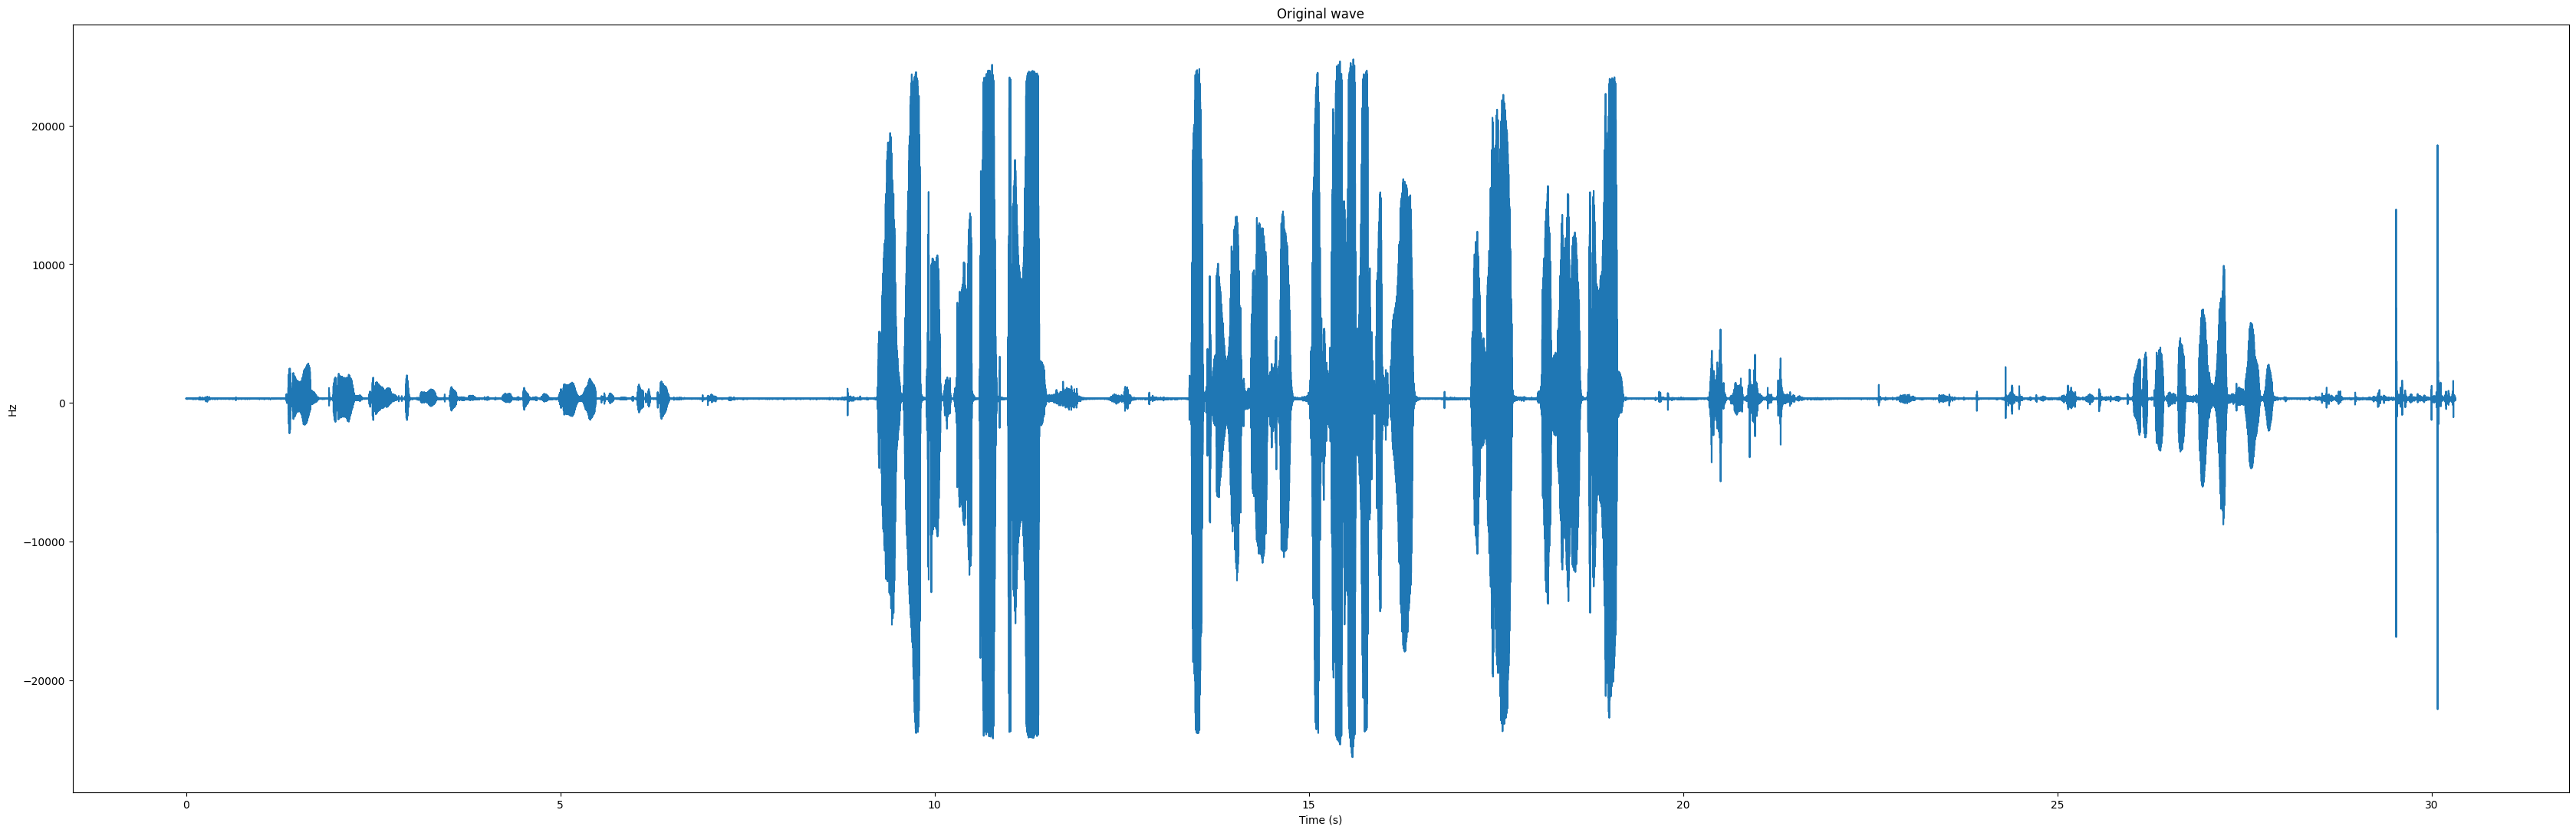

In [9]:
origPlotData = np.frombuffer(origData, np.int16)
origDataLen = len(origPlotData)
time = np.linspace(0, origDataLen / origRate, num = origDataLen)
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Original wave")
plt.plot(time, origPlotData)
plt.show()

In [10]:
processedData = origPlotData.copy()
processedDataLen = len(processedData)
print(f"len = {processedDataLen}")
STEP = 3000
flag = True
for i in range(0, processedDataLen, STEP):
    subStep = i + STEP
    if (subStep >= processedDataLen):
        break

    # TODO: передавать в обработку data[i, subStep]
        
    for j in range(i, subStep):
        processedData[j] = np.iinfo(np.int16).max if flag else np.iinfo(np.int16).min

    if flag:
        flag = False
    else:
        flag = True

len = 242560


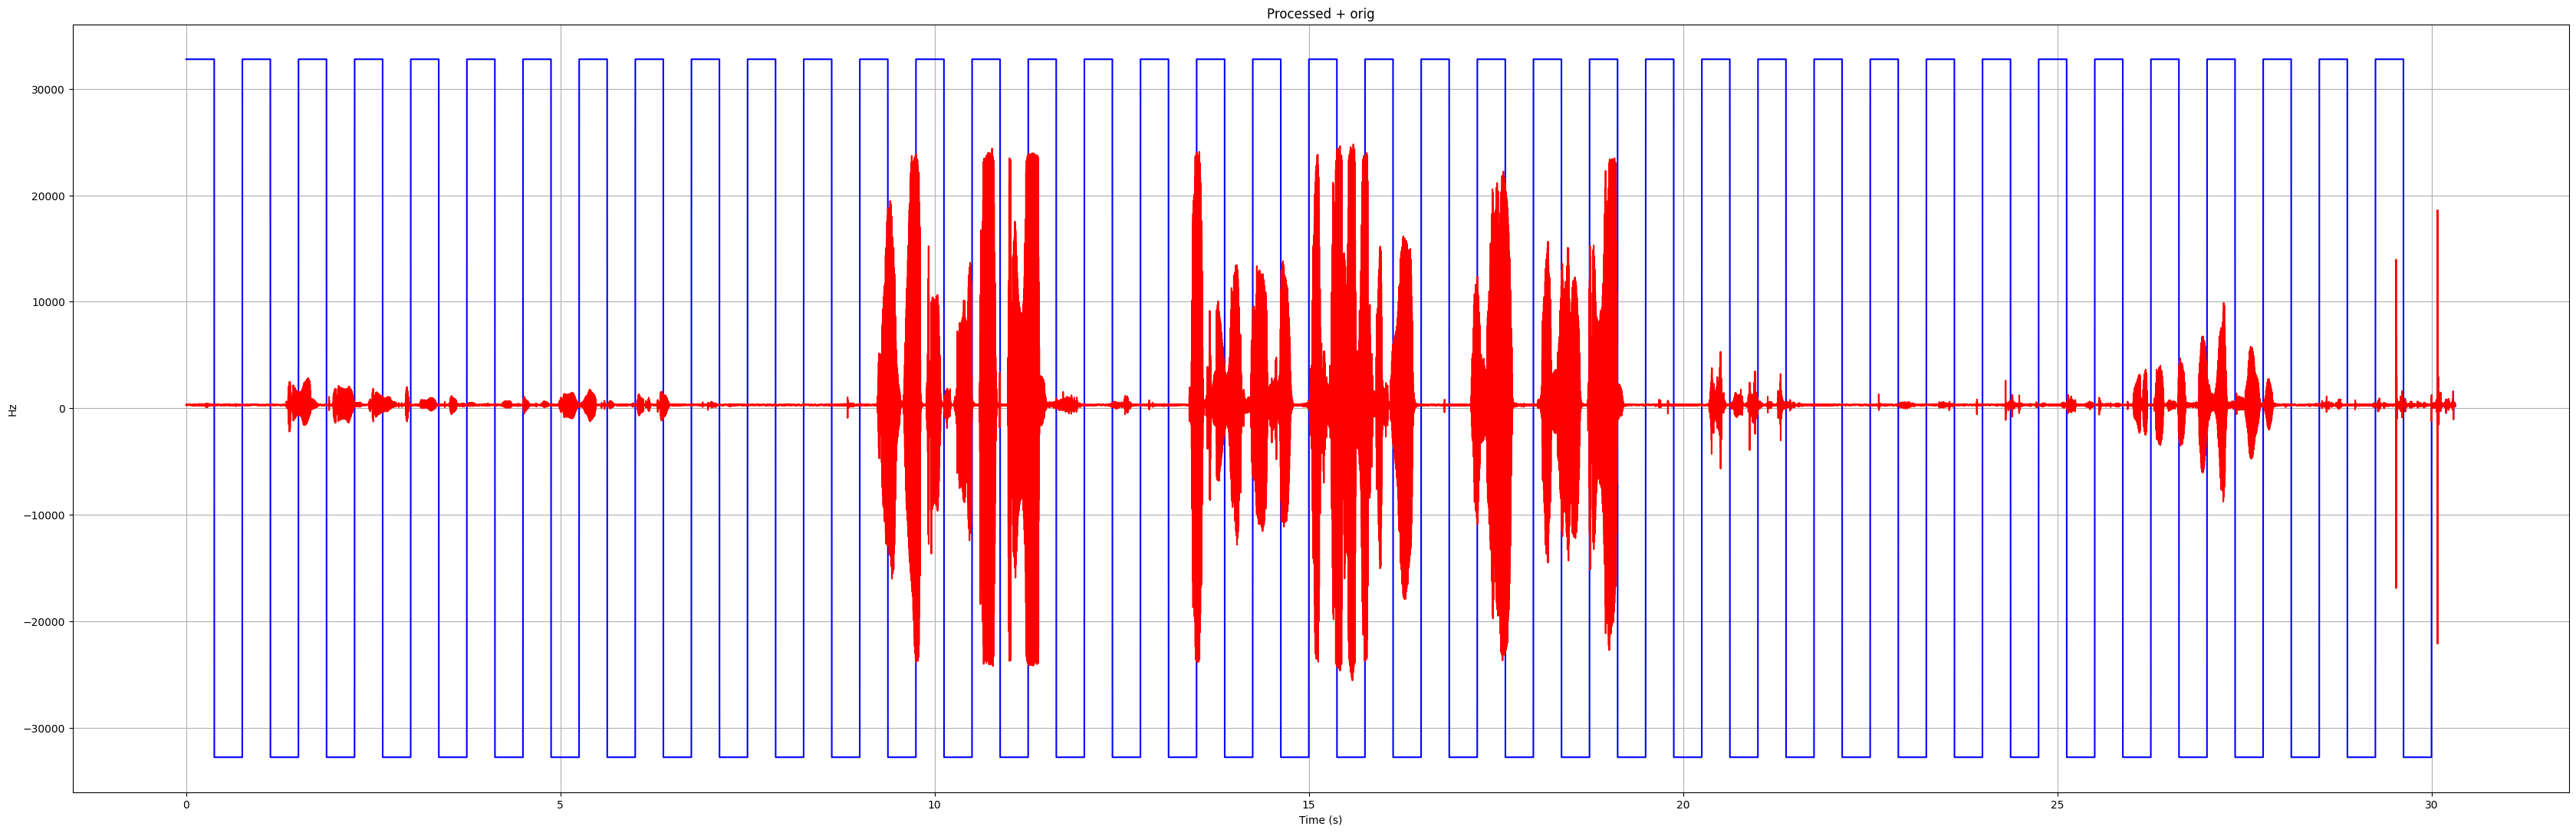

In [11]:
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Processed + orig")
plt.plot(time, processedData, color = 'b')
plt.plot(time, origPlotData, color = 'r')
plt.grid(True)
plt.show()